Detailed explanation: https://medium.com/@alexppppp/how-to-train-an-ensemble-of-convolutional-neural-networks-for-image-classification-8fc69b087d3

GitHub repo: https://github.com/alexppppp/tinyimagenet-classification-ensemble

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

if torch.cuda.is_available():
    print('CUDA is available. Working on GPU')
    DEVICE = torch.device('cuda')
else:
    print('CUDA is not available. Working on CPU')
    DEVICE = torch.device('cpu')

CUDA is available. Working on GPU


# Downloading dataset

In [2]:
!wget -O tiny-imagenet-200.zip http://cs231n.stanford.edu/tiny-imagenet-200.zip

In [3]:
!unzip tiny-imagenet-200.zip

# Data processing

In [4]:
DIR_MAIN = 'tiny-imagenet-200/'
DIR_TRAIN = DIR_MAIN + 'train/'
DIR_VAL = DIR_MAIN + 'val/'
DIR_TEST = DIR_MAIN + 'test/'

# Number of labels - 200
labels = os.listdir(DIR_TRAIN)

# Initialize labels encoder
encoder_labels = LabelEncoder()
encoder_labels.fit(labels)

# Create lists of files and labels for training (100'000 items)
files_train = []
labels_train = []
for label in labels:
    for filename in os.listdir(DIR_TRAIN + label + '/images/'):
        files_train.append(DIR_TRAIN + label + '/images/' + filename)
        labels_train.append(label)

# Create lists of files and labels for validation (10'000 items)
files_val = []
labels_val = []
for filename in os.listdir(DIR_VAL + 'images/'):
    files_val.append(DIR_VAL + 'images/' + filename)

val_df = pd.read_csv(DIR_VAL + 'val_annotations.txt', sep='\t', names=["File", "Label", "X1", "Y1", "X2", "Y2"], usecols=["File", "Label"])
for f in files_val:
    l = val_df.loc[val_df['File'] == f[len(DIR_VAL + 'images/'):]]['Label'].values[0]
    labels_val.append(l)

# List of files for testing (10'000 items)
files_test = []
for filename in os.listdir(DIR_TEST + 'images/'):
    files_test.append(DIR_TEST + 'images/' + filename)
    files_test = sorted(files_test)
    
print("The first five files from the list of train images:", files_train[:5])
print("\nThe first five labels from the list of train labels:", labels_train[:5])
print("\nThe first five files from the list of validation images:", files_val[:5])
print("\nThe first five labels from the list of validation labels:", labels_val[:5])
print("\nThe first five files from the list of test images:", files_test[:5])

The first five files from the list of train images: ['tiny-imagenet-200/train/n03970156/images/n03970156_391.JPEG', 'tiny-imagenet-200/train/n03970156/images/n03970156_35.JPEG', 'tiny-imagenet-200/train/n03970156/images/n03970156_405.JPEG', 'tiny-imagenet-200/train/n03970156/images/n03970156_92.JPEG', 'tiny-imagenet-200/train/n03970156/images/n03970156_162.JPEG']

The first five labels from the list of train labels: ['n03970156', 'n03970156', 'n03970156', 'n03970156', 'n03970156']

The first five files from the list of validation images: ['tiny-imagenet-200/val/images/val_9055.JPEG', 'tiny-imagenet-200/val/images/val_682.JPEG', 'tiny-imagenet-200/val/images/val_2456.JPEG', 'tiny-imagenet-200/val/images/val_7116.JPEG', 'tiny-imagenet-200/val/images/val_2825.JPEG']

The first five labels from the list of validation labels: ['n03584254', 'n04008634', 'n02206856', 'n04532670', 'n01770393']

The first five files from the list of test images: ['tiny-imagenet-200/test/images/test_0.JPEG', 'ti

# Dataset

In [5]:
class ImagesDataset(Dataset):
    def __init__(self, files, labels, encoder, transforms, mode):
        super().__init__()
        self.files = files
        self.labels = labels
        self.encoder = encoder
        self.transforms = transforms
        self.mode = mode

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        pic = Image.open(self.files[index]).convert('RGB')

        if self.mode == 'train' or self.mode == 'val':
            x = self.transforms(pic)
            label = self.labels[index]
            y = self.encoder.transform([label])[0]
            return x, y
        elif self.mode == 'test':
            x = self.transforms(pic)
            return x, self.files[index]
        
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    transforms.RandomErasing(p=0.5, scale=(0.06, 0.08), ratio=(1, 3), value=0, inplace=True)
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262])
])

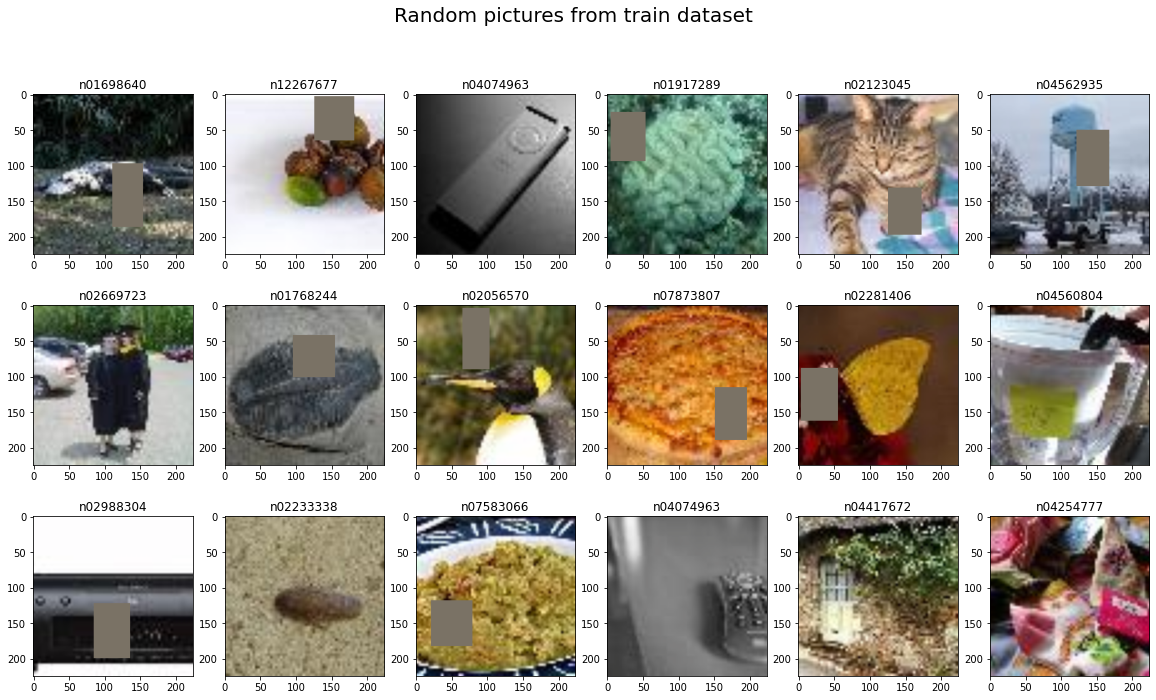

In [6]:
train_dataset = ImagesDataset(files=files_train,
                              labels=labels_train,
                              encoder=encoder_labels,
                              transforms=transforms_train,
                              mode='train')

val_dataset = ImagesDataset(files=files_val,
                            labels=labels_val,
                            encoder=encoder_labels,
                            transforms=transforms_val,
                            mode='val')

test_dataset = ImagesDataset(files=files_test,
                             labels=None,
                             encoder=None,
                             transforms=transforms_val,
                             mode='test')

fig, axs = plt.subplots(3, 6, figsize=(20,11))
fig.suptitle('Random pictures from train dataset', fontsize=20)
for ax in axs.flatten():
    n = np.random.randint(len(train_dataset))
    img = train_dataset[n][0]
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.4802, 0.4481, 0.3975])
    std = np.array([0.2302, 0.2265, 0.2262])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.set_title(encoder_labels.inverse_transform([train_dataset[n][1]])[0])
    ax.imshow(img)

# Functions for training models

In [7]:
def training(model, model_name, num_epochs, train_dataloader, val_dataloader):

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.33)

    train_loss_array = []
    train_acc_array = []
    val_loss_array = []
    val_acc_array = []
    lowest_val_loss = np.inf
    best_model = None

    for epoch in tqdm(range(num_epochs)):

        print('Epoch: {} | Learning rate: {}'.format(epoch + 1, scheduler.get_lr()))

        for phase in ['train', 'val']:

            epoch_loss = 0
            epoch_correct_items = 0
            epoch_items = 0

            if phase == 'train':
                model.train()
                with torch.enable_grad():
                    for samples, targets in train_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        optimizer.zero_grad()
                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()
                        
                        loss.backward()
                        optimizer.step()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)
                print(epoch_items)

                train_loss_array.append(epoch_loss / epoch_items)
                train_acc_array.append(epoch_correct_items / epoch_items)

                scheduler.step()

            elif phase == 'val':
                model.eval()
                with torch.no_grad():
                    for samples, targets in val_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)
                print(epoch_items)

                val_loss_array.append(epoch_loss / epoch_items)
                val_acc_array.append(epoch_correct_items / epoch_items)

                if epoch_loss / epoch_items < lowest_val_loss:
                    lowest_val_loss = epoch_loss / epoch_items
                    torch.save(model.state_dict(), '{}_weights.pth'.format(model_name))
                    best_model = copy.deepcopy(model)
                    print("\t| New lowest val loss for {}: {}".format(model_name, lowest_val_loss))

    return best_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array

In [8]:
def visualize_training_results(train_loss_array,
                               val_loss_array,
                               train_acc_array,
                               val_acc_array,
                               num_epochs,
                               model_name,
                               batch_size):
    fig, axs = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle("{} training | Batch size: {}".format(model_name, batch_size), fontsize = 16)
    axs[0].plot(list(range(1, num_epochs+1)), train_loss_array, label="train_loss")
    axs[0].plot(list(range(1, num_epochs+1)), val_loss_array, label="val_loss")
    axs[0].legend(loc='best')
    axs[0].set(xlabel='epochs', ylabel='loss')
    axs[1].plot(list(range(1, num_epochs+1)), train_acc_array, label="train_acc")
    axs[1].plot(list(range(1, num_epochs+1)), val_acc_array, label="val_acc")
    axs[1].legend(loc='best')
    axs[1].set(xlabel='epochs', ylabel='accuracy')
    plt.show();

# Training

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
num_epochs = 15

### Training DenseNet161

In [ ]:
model_densenet161 = models.densenet161(pretrained=True)
for param in model_densenet161.parameters():
    param.requires_grad = False
model_densenet161.classifier = torch.nn.Linear(model_densenet161.classifier.in_features, out_features=200)
model_densenet161 = model_densenet161.to(DEVICE)

densenet161_training_results = training(model=model_densenet161,
                                        model_name='DenseNet161',
                                        num_epochs=num_epochs,
                                        train_dataloader=train_dataloader,
                                        val_dataloader=val_dataloader)

model_densenet161, train_loss_array, train_acc_array, val_loss_array, val_acc_array = densenet161_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="DenseNet161",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

### Training ResNet152

In [ ]:
model_resnet152 = models.resnet152(pretrained=True)
for param in model_resnet152.parameters():
    param.requires_grad = False
model_resnet152.fc = torch.nn.Linear(model_resnet152.fc.in_features, 200)
model_resnet152 = model_resnet152.to(DEVICE)

resnet152_training_results = training(model=model_resnet152,
                                      model_name='ResNet152',
                                      num_epochs=num_epochs,
                                      train_dataloader=train_dataloader,
                                      val_dataloader=val_dataloader)

model_resnet152, train_loss_array, train_acc_array, val_loss_array, val_acc_array = resnet152_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="ResNet152",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

### Training VGG19

In [ ]:
model_vgg19_bn = models.vgg19_bn(pretrained=True)
for param in model_vgg19_bn.parameters():
    param.requires_grad = False
model_vgg19_bn.classifier[6] = torch.nn.Linear(in_features=model_vgg19_bn.classifier[6].in_features, out_features=200)
model_vgg19_bn = model_vgg19_bn.to(DEVICE)

vgg19_bn_training_results = training(model=model_vgg19_bn,
                                     model_name='VGG19_bn',
                                     num_epochs=num_epochs,
                                     train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader)

model_vgg19_bn, train_loss_array, train_acc_array, val_loss_array, val_acc_array = vgg19_bn_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="VGG19_bn",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

### Training ensemble

In [ ]:
# In case we want to use saved weights 

# model_vgg19_bn = models.vgg19_bn(pretrained = False)
# model_vgg19_bn.classifier[6] = torch.nn.Linear(in_features=4096, out_features=200)

# model_resnet152 = models.resnet152(pretrained = False)
# model_resnet152.fc = torch.nn.Linear(in_features=2048, out_features=200)

# model_densenet161 = models.densenet161(pretrained = False)
# model_densenet161.classifier = torch.nn.Linear(in_features=2208, out_features=200)

# model_vgg19_bn.load_state_dict(torch.load('VGG19_bn_weights.pth'))
# model_resnet152.load_state_dict(torch.load('ResNet152_weights.pth'))
# model_densenet161.load_state_dict(torch.load('DenseNet161_weights.pth'))

In [ ]:
class EnsembleModel(nn.Module):   
    def __init__(self, modelA, modelB, modelC):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC
        self.classifier = nn.Linear(200 * 3, 200)
        
    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x3 = self.modelC(x)
        x = torch.cat((x1, x2, x3), dim=1)
        out = self.classifier(x)
        return out
    
ensemble_model = EnsembleModel(model_densenet161, model_resnet152, model_vgg19_bn)

for param in ensemble_model.parameters():
    param.requires_grad = False

for param in ensemble_model.classifier.parameters():
    param.requires_grad = True    

ensemble_model = ensemble_model.to(DEVICE)

In [ ]:
ensemble_training_results = training(model=ensemble_model,
                                     model_name='Ensemble',
                                     num_epochs=20,
                                     train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader)

ensemble_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array = ensemble_training_results

min_loss = min(val_loss_array)
min_loss_iteration = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_iteration]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs=20,
                           model_name="Ensemble model",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during iteration #{}".format(min_loss, min_loss_iteration + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

# Classifying test dataset and saving results to csv-file

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

all_preds = []
all_files = []

ensemble_model.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader):
        samples = samples.to(DEVICE)
        outputs = ensemble_model(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_files.extend(f_names)

all_filenames = [f_name[30:] for f_name in all_files]
all_preds_decoded = encoder_labels.inverse_transform(all_preds)

submission_ensemble_df = pd.DataFrame(list(zip(all_filenames, all_preds_decoded)), columns =['File', 'Prediction'])
submission_ensemble_df.to_csv('test_predictions_ensemble.csv', header=False, index=False) 
submission_ensemble_df.head(10)